# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline
import torch

from ddpg_agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


### 4. Implement and train an agent to the environment

In [6]:
# Initialize our agent
seed=17
agent = Agent(state_size = state_size, action_size = action_size, seed = seed)

In [7]:
def ddpg(n_episodes=1000):
    """
    This function is used to march through a defined number of epochs
    for navigating our environment.  Within an epoch, for each step, an action
    is chosen for each agent given the current states for each agent 
    and then we determine from the environment our reward, next_state and whether the
    epoch is completed.  Within the step we then conducts 
    learning activities for the agent.
    
    :param n_episodes: (int) the number of epochs
    
    :return: (array_like) calculated scores for each epoch
    """
    score = []
    score_window = deque(maxlen=100)                         # last 100 scores
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]    # reset the environment
        states = env_info.vector_observations                # get the current state
        scores = np.zeros(num_agents)                        # initialize the score
        agent.reset()                                        # reset OU noise
        done = False
        while not done:
            actions = agent.act(states)                      # select an action for each agent
            env_info = env.step(actions)[brain_name]         # send all actions to the environment
            next_states = env_info.vector_observations       # get the next state for each agent
            rewards = env_info.rewards                       # get the reward for each agent
            dones = env_info.local_done                      # see if episode has finished
            for i_agent in range(num_agents):                # increment over our agents
                agent.step(states[i_agent], actions[i_agent], rewards[i_agent], next_states[i_agent], dones[i_agent])
            scores += env_info.rewards                       # update the score for each agent
            states = next_states                             # roll over the state to next time step
            if np.any(dones):                                # if any agent has finished, end the episode
                done = True
        score.append(np.mean(scores))
        score_window.append(np.mean(scores))
        if i_episode % 20 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(score_window)))
        if np.mean(score_window)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(score_window)))
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            break
    return score

Train our agent, showing incremental scores (averaged over prior 100 epochs), and then show a graph of our scores per epoch.

Episode 20	Average Score: 0.94
Episode 40	Average Score: 2.04
Episode 60	Average Score: 4.11
Episode 80	Average Score: 5.66
Episode 100	Average Score: 7.38
Episode 120	Average Score: 10.68
Episode 140	Average Score: 14.74
Episode 160	Average Score: 18.44
Episode 180	Average Score: 22.67
Episode 200	Average Score: 26.45
Episode 220	Average Score: 29.83

Environment solved in 122 episodes!	Average Score: 30.07


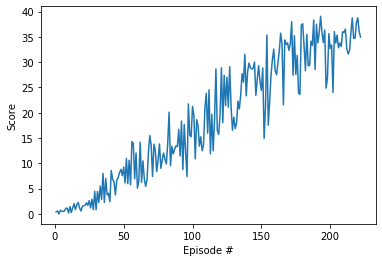

In [8]:
scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Save the model waits for our critic and actor networks.

In [9]:
actor_model_weights = agent.actor_local.state_dict()
critic_model_weights = agent.critic_local.state_dict()
torch.save(actor_model_weights, '.actor_model_weights.pth')
torch.save(critic_model_weights, '.critic_model_weights.pth')

When finished, we can close the environment.

In [12]:
#env.close()